# Thinkful Data Science Final Capstone
## News Article Summarization Using Keras RNNs

Facing an increasingly polarized readership, news publications commonly resort to biased journalism along a sociopolitical spectrum of left or right leaning subjectivity. Websites like Vox and Breitbart News cover many of the same stories, but from entirely different perspectives intended to enhance the confirmation bias of the reader, a proven customer retention strategy. 

A recently created website, [Knowhere](http://www.knowhere.com) attempts to appease both sides and the middle by publishing news stories three ways, with labels of "Impartial", "Left", & "Right" readers can choose from. This is accomplished using a combination of human editors, scraping AI, and NLP machine learning models used to encode and decode the articles according to weights. 

A crucial aspect of the NLP models is the summarization of published news articles. This presents a particular challenge as articles are often 700+ words. Smaller texts, like tweets, comments, and product reviews are often only a few hundred characters presenting a single idea. News articles give backstory, context, and different perspectives (even if only to marginalize that perspective). 

In this capstone I have attempted to create a text summarizer for 3,000 articles published in September and October 2018 on four websites, listed left to right by subjective bias in journalism from left to right Huffington Post, Politico, BBC US, and The Daily Caller. 

![The Daily Caller Front Page 10-24-18](dailycaller102418.png "The Daily Caller Front Page 10-24-18")

First, I created a spider to scrape the websites across their respective front pages, going into each article to capture the headline, date, and article text. I did this every 48-72 hours using four separate .py files (dc_recursive, huffpo, politico, & bbcus. 

In [1]:
import pandas as pd
import spacy
import itertools as it
import os
import numpy as np
import re
import scipy
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
%matplotlib inline

In [2]:
# Daily Caller Scraper using Scrapy

if 1 == 0:
    from scrapy.linkextractors import LinkExtractor
    from scrapy import Selector
    from dailycaller.items import DailycallerItem
    from scrapy.spiders import Spider 
    from scrapy.crawler import CrawlerProcess 
    import scrapy

    BASE_URL = 'https://dailycaller.com'

    articles = []

    class QuotesSpider(scrapy.Spider): 
        name = "dailycaller" 
        start_urls = [BASE_URL]

        def parse(self, response):
            article_links = response.xpath('//article/a/@href')
            for link in article_links:
                #TODO: get a better relative link handler
                yield scrapy.Request(BASE_URL + link.extract(), callback=self.parse_article)

        def parse_article(self, response):
            title = response.xpath('//h1/text()')[0].extract()
            time = response.xpath('//time/text()')[0].extract()
            text = '\\n\\n'.join(map(lambda x: x.extract(), response.xpath('//p/text()')))
            yield {'Title': title, 'Date': time, 'Article':text}

The Daily Caller csv is obtained by running a scrape in Command using Sublime text editor code:

scrapy crawl dailycaller -o dcrXXXX.csv -t csv ("XXXX" indicating the date of the scrape) 

![News Scrape Using Command Prompt](scrapycommand.png "News Scrape Using Command Prompt")

The same can be done for similar scraping code written for Politico (politico), Huffington Post (huffpo) and BBC US (bbcus). For each scrape's CSV I manually inspect the articles and eliminate those where the scrape failed to properly collect the headline or article. This was most common in BBC US articles that would often using a recurring headline for geographic areas or topics such as "Africa" and "Health", usually accounting for approximately 30% of BBC scrapes. Just as common, though to a lesser extent, about 5% of The Daily Caller articles, mostly from the "Opinion" section would return empty space for the article.

Next I read the CSVs in and began preprocessing:

# Preprocessing

In [3]:
#Define the DataFrames
dcr = pd.read_csv('C:\\Users\\mkesslar\\Desktop\\Thinkful\\DS Bootcamp\\dailycaller\\dcr Man_Cleaned.csv')
huffpo = pd.read_csv('C:\\Users\\mkesslar\\Desktop\\Thinkful\\DS Bootcamp\\dailycaller\\huffpo Man_Cleaned.csv')
pol = pd.read_csv('C:\\Users\\mkesslar\\Desktop\\Thinkful\\DS Bootcamp\\dailycaller\\politico Man_Cleaned.csv')
bbc = pd.read_csv('C:\\Users\\mkesslar\\Desktop\\Thinkful\\DS Bootcamp\\dailycaller\\bbcus Man_Cleaned.csv')

In [4]:
# Inspect
print(dcr.shape)
print(huffpo.shape)
print(pol.shape)
print(bbc.shape)

(1085, 3)
(466, 3)
(906, 3)
(545, 3)


In [5]:
pd.options.display.max_colwidth = 1000
dcr.head(2)

,Title,Date,Article
0,CNN’s Brian Stelter Promised Us He’d Be On Vacation This Week – What Happened?,1:03 PM 08/30/2018,"CNN’s alleged media reporter \n\n is on vacation this week. We don’t know this because he’s suddenly missing from the political bubble. We know it because he claimed that he had temporarily disabled his Twitter feed — to, ahem, spend time with the fam — but then we were forced to see the contents of his large head spilling out into the Twittersphere.\n\nAll. Week. Long.\n\nCan’t we have seven days of no Stelter in peace?\n\nThe short answer is: No.\n\nFour days prior to the alleged vacation, \n\n quietly received word that Stelter would be off starting Sunday night.\n\nHis colleague, \n\n, has taken over his late-night newsletter, which he began publishing Sunday. But there’s Stelter….hovering. We are subjected to his amateur sunset photograph that insists he’s on vacation when he’s really incessantly working half the time.\n\nIs there anything \n\n annoying?\n\nWell, yeah.\n\nMaybe the worst of this Stelter windstorm arrived in our inboxes Wednesday night when he shared what amoun..."
1,Confusion In Super Close Alaska Primary After 17 Voter Registrations Trace Back To A Single Mobile Home,1:10 PM 09/01/2018,"A potential investigation hangs over an Alaska State House Republican primary after the race came down to a few votes, but irregularities like 17 voter registrations that trace back to a single mobile home address caught the attention of the Alaska Division of Elections.\n\nIncumbent Gabrielle LeDoux leads challenger Aaron Weaver \n\n after Tuesday’s election, but at least 26 absentee ballots for LeDoux are classified as “suspect” by the state Division of Elections, \n\n.\n\nThe state Republican Party Chairman Tuckerman Babcock is calling for an investigation. LeDoux fell out of favor with her party in 2016 after she \n\n.\n\nThe 17 Republican voter registrations linked to a single mobile home are in a section of House District 15 that is home to members of the Chinese Hmong community. A woman who answered the door of the mobile home and identified herself as Laura Chang told KTVA she did not know many of the people who registered to vote using the address. \n\nAnother mobile home ..."


First, I need to strip the data of some tags and extra space. Regular Expressions affected the rest of the article in negative ways, particularly the fowardslash removal. Individually, the function works. A couple extra doublespaces are of no concern. So I used a .replace function instead. 

In [6]:
dcr['Article'][1]

'A potential investigation hangs over an Alaska State House Republican primary after the race came down to a few votes, but irregularities like 17 voter registrations that trace back to a single mobile home address caught the attention of the Alaska Division of Elections.\\n\\nIncumbent Gabrielle LeDoux leads challenger Aaron Weaver \\n\\n after Tuesday’s election, but at least 26 absentee ballots for LeDoux are classified as “suspect” by the state Division of Elections, \\n\\n.\\n\\nThe state Republican Party Chairman Tuckerman Babcock is calling for an investigation. LeDoux fell out of favor with her party in 2016 after she \\n\\n.\\n\\nThe 17 Republican voter registrations linked to a single mobile home are in a section of House District 15 that is home to members of the Chinese Hmong community. A woman who answered the door of the mobile home and identified herself as Laura Chang told KTVA she did not know many of the people who registered to vote using the address.\xa0\\n\\nAnothe

In [7]:
def modify(text):
    text = text.replace('\\n', ' ')
    text = text.replace('\\\\n', ' ')
    text = text.replace('CORPORATE', '')
    text = text.replace('COLUMNS', '')
    text = text.replace('SECTIONS', '')
    text = text.replace('\xa0', ' ')
    text = text.replace('  ',' ')
    return(text)

In [8]:
dcr['Article_M'] = dcr['Article'].apply(modify)

In [9]:
dcr['Article_M'][1]

'A potential investigation hangs over an Alaska State House Republican primary after the race came down to a few votes, but irregularities like 17 voter registrations that trace back to a single mobile home address caught the attention of the Alaska Division of Elections. Incumbent Gabrielle LeDoux leads challenger Aaron Weaver  after Tuesday’s election, but at least 26 absentee ballots for LeDoux are classified as “suspect” by the state Division of Elections,  . The state Republican Party Chairman Tuckerman Babcock is calling for an investigation. LeDoux fell out of favor with her party in 2016 after she  . The 17 Republican voter registrations linked to a single mobile home are in a section of House District 15 that is home to members of the Chinese Hmong community. A woman who answered the door of the mobile home and identified herself as Laura Chang told KTVA she did not know many of the people who registered to vote using the address.  Another mobile home in the same park has 14 r

In [10]:
# review the length of the articles
dcr['Article_length'] = dcr['Article'].apply(len)

In [11]:
dcr['Article_length'].head()

0    3347
1    2018
2    1477
3    2054
4    2560
Name: Article_length, dtype: int64

In [12]:
dcr['Article_length'].describe()

count     1085.000000
mean      2831.541014
std       2087.460691
min         62.000000
25%       1468.000000
50%       2162.000000
75%       3799.000000
max      31379.000000
Name: Article_length, dtype: float64

{'boxes': [<matplotlib.lines.Line2D at 0x10d7a2c5b70>],
 'caps': [<matplotlib.lines.Line2D at 0x10d7a2dc5c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x10d7a2e6278>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10d7a2dce10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x10d7a2c5cc0>,
  <matplotlib.lines.Line2D at 0x10d7a2dc198>]}

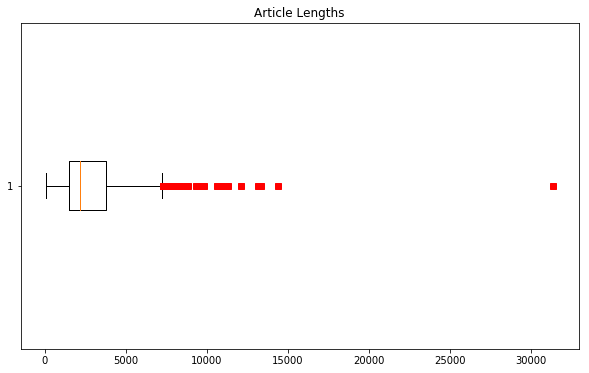

In [13]:
plt.figure(figsize=(10,6))
plt.title('Article Lengths')
plt.boxplot(dcr['Article_length'], 0, 'rs', 0)

If this were numerical data to be analyzed these outliers would be problematic, as would the min. However, regardless of the article lengths I am going to parse the articles so that I can clean them for vectorization. 

In [14]:
nlp = spacy.load('en')

In [15]:
dcr['Articles_Parsed'] = [nlp(article) for article in dcr['Article_M']]

In [16]:
dcr['Articles_Parsed'].head(2)

0                                                                                                                      (CNN, ’s, alleged, media, reporter,  , is, on, vacation, this, week, ., We, do, n’t, know, this, because, he, ’s, suddenly, missing, from, the, political, bubble, ., We, know, it, because, he, claimed, that, he, had, temporarily, disabled, his, Twitter, feed, —, to, ,, ahem, ,, spend, time, with, the, fam, —, but, then, we, were, forced, to, see, the, contents, of, his, large, head, spilling, out, into, the, Twittersphere, ., All, ., Week, ., Long, ., Ca, n’t, we, have, seven, days, of, no, Stelter, in, peace, ?, The, short, answer, is, :, No, ., Four, days, prior, to, ...)
1    (A, potential, investigation, hangs, over, an, Alaska, State, House, Republican, primary, after, the, race, came, down, to, a, few, votes, ,, but, irregularities, like, 17, voter, registrations, that, trace, back, to, a, single, mobile, home, address, caught, the, attention, of, the, Alaska, Di

The articles parsed, I next lemmatize, lowercase, and remove stopwords and punctuation

In [17]:
lemmatizer = WordNetLemmatizer()

In [18]:
stopWords = stopwords.words('english')

def cleanData(sentence):
    processedList = ""
   
   # convert to lowercase, ignore all special characters - keep only alpha-numericals and spaces (not removing full-stop here)
    sentence = re.sub(r'[^A-Za-z0-9\s.]',r'',str(sentence).lower())
    sentence = re.sub(r'\n',r' ',sentence)
   
   # remove stop words
    sentence = [word for word in sentence.split() if word not in stopWords]
   
    return sentence

In [19]:
# Remove stopwords 
dcr['Articles_Cleaned'] = (dcr['Articles_Parsed']).apply(cleanData)

The articles can't be fed through the Recurrant Neural Network in their current state of lists of tokens. So I merge them back together. 

In [20]:
def rejoin(text):
    return " ".join(text)

In [21]:
dcr['Joined'] = dcr['Articles_Cleaned'].apply(lambda x: rejoin(x))

In [22]:
dcr['Joined'][0]

'cnns alleged media reporter vacation week. dont know hes suddenly missing political bubble. know claimed temporarily disabled twitter feed ahem spend time fam forced see contents large head spilling twittersphere. all. week. long. cant seven days stelter peace short answer no. four days prior alleged vacation quietly received word stelter would starting sunday night. colleague taken latenight newsletter began publishing sunday. theres stelter.hovering. subjected amateur sunset photograph insists hes vacation hes really incessantly working half time. anything annoying well yeah. maybe worst stelter windstorm arrived inboxes wednesday night shared amounts big fat lie nightly newsletter written darcy. stelter emails uninstalled twitter. fake news went town coffee newspapers. cares took sunny bay. cute still cares picked seashells. ditto fish flatbreads dinner. need know went see crazy rich asians jame loved it. really one cares gobs journalists pundits able willing bash week really need 

In [23]:
# Remove unneeded columnds
dcr.columns

Index(['Title', 'Date', 'Article', 'Article_M', 'Article_length',
       'Articles_Parsed', 'Articles_Cleaned', 'Joined'],
      dtype='object')

In [24]:
cols = ['Title', 'Date', 'Joined']
dcr = pd.DataFrame(dcr, columns=cols)
dcr.head(2)

,Title,Date,Joined
0,CNN’s Brian Stelter Promised Us He’d Be On Vacation This Week – What Happened?,1:03 PM 08/30/2018,cnns alleged media reporter vacation week. dont know hes suddenly missing political bubble. know claimed temporarily disabled twitter feed ahem spend time fam forced see contents large head spilling twittersphere. all. week. long. cant seven days stelter peace short answer no. four days prior alleged vacation quietly received word stelter would starting sunday night. colleague taken latenight newsletter began publishing sunday. theres stelter.hovering. subjected amateur sunset photograph insists hes vacation hes really incessantly working half time. anything annoying well yeah. maybe worst stelter windstorm arrived inboxes wednesday night shared amounts big fat lie nightly newsletter written darcy. stelter emails uninstalled twitter. fake news went town coffee newspapers. cares took sunny bay. cute still cares picked seashells. ditto fish flatbreads dinner. need know went see crazy rich asians jame loved it. really one cares gobs journalists pundits able willing bash week really ne...
1,Confusion In Super Close Alaska Primary After 17 Voter Registrations Trace Back To A Single Mobile Home,1:10 PM 09/01/2018,potential investigation hangs alaska state house republican primary race came votes irregularities like 17 voter registrations trace back single mobile home address caught attention alaska division elections. incumbent gabrielle ledoux leads challenger aaron weaver tuesdays election least 26 absentee ballots ledoux classified suspect state division elections . state republican party chairman tuckerman babcock calling investigation. ledoux fell favor party 2016 . 17 republican voter registrations linked single mobile home section house district 15 home members chinese hmong community. woman answered door mobile home identified laura chang told ktva know many people registered vote using address. another mobile home park 14 registered republicans according voter registrations . irregularities voter registrations appear trace back single man charlie chang. ledoux reportedly flew chang california paid 10000 help get vote hmong community district according campaign finance reports cited...


In [25]:
# Finally, I export the CSV to be used by the Python files containing the RNN, training, and predict functions. 
dcr.to_csv('C:\\Users\\mkesslar\\Desktop\\Thinkful\\DS Bootcamp\\keras-text-summarization-master\\demo\\dcr Man_Cleaned.csv')

# Summarizations

Next came a series of summarization tactics, mostly using Recurrant Neural Networks. Though all are available in the 'RNNs' folder on my git, the code below is for RNN1, the one that had the best results, 

In [26]:
#News Loader
if 1 == 0:
    from collections import Counter

    MAX_INPUT_SEQ_LENGTH = 500
    MAX_TARGET_SEQ_LENGTH = 50
    MAX_INPUT_VOCAB_SIZE = 5000
    MAX_TARGET_VOCAB_SIZE = 2000


    def fit_text(X, Y, input_seq_max_length=None, target_seq_max_length=None):
        if input_seq_max_length is None:
            input_seq_max_length = MAX_INPUT_SEQ_LENGTH
        if target_seq_max_length is None:
            target_seq_max_length = MAX_TARGET_SEQ_LENGTH
        input_counter = Counter()
        target_counter = Counter()
        max_input_seq_length = 0
        max_target_seq_length = 0

        for line in X:
            # for word in line: 
            #     if isinstance(word, float): print("ERROR IS HERE", word)
            text = [word.lower() for word in line.split(' ')]
            seq_length = len(text)
            if seq_length > input_seq_max_length:
                text = text[0:input_seq_max_length]
                seq_length = len(text)
            for word in text:
                input_counter[word] += 1
            max_input_seq_length = max(max_input_seq_length, seq_length)

        for line in Y:
            line2 = 'START ' + line.lower() + ' END'
            text = [word for word in line2.split(' ')]
            seq_length = len(text)
            if seq_length > target_seq_max_length:
                text = text[0:target_seq_max_length]
                seq_length = len(text)
            for word in text:
                target_counter[word] += 1
                max_target_seq_length = max(max_target_seq_length, seq_length)

        input_word2idx = dict()
        for idx, word in enumerate(input_counter.most_common(MAX_INPUT_VOCAB_SIZE)):
            input_word2idx[word[0]] = idx + 2
        input_word2idx['PAD'] = 0
        input_word2idx['UNK'] = 1
        input_idx2word = dict([(idx, word) for word, idx in input_word2idx.items()])

        target_word2idx = dict()
        for idx, word in enumerate(target_counter.most_common(MAX_TARGET_VOCAB_SIZE)):
            target_word2idx[word[0]] = idx + 1
        target_word2idx['UNK'] = 0

        target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])

        num_input_tokens = len(input_word2idx)
        num_target_tokens = len(target_word2idx)

        config = dict()
        config['input_word2idx'] = input_word2idx
        config['input_idx2word'] = input_idx2word
        config['target_word2idx'] = target_word2idx
        config['target_idx2word'] = target_idx2word
        config['num_input_tokens'] = num_input_tokens
        config['num_target_tokens'] = num_target_tokens
        config['max_input_seq_length'] = max_input_seq_length
        config['max_target_seq_length'] = max_target_seq_length

        return config

In [27]:
# RNN1

if 1 == 0:
    class RecursiveRNN1(object):
        model_name = 'recursive-rnn-1'
        """
        A second alternative model is to develop a model that generates a single word forecast and call it recursively.

        That is, the decoder uses the context vector and the distributed representation of all words generated so far as 
        input in order to generate the next word. 

        A language model can be used to interpret the sequence of words generated so far to provide a second context vector 
        to combine with the representation of the source document in order to generate the next word in the sequence.

        The summary is built up by recursively calling the model with the previously generated word appended (or, more 
        specifically, the expected previous word during training).

        The context vectors could be concentrated or added together to provide a broader context for the decoder to 
        interpret and output the next word.
        """

        def __init__(self, config):
            self.num_input_tokens = config['num_input_tokens']
            self.max_input_seq_length = config['max_input_seq_length']
            self.num_target_tokens = config['num_target_tokens']
            self.max_target_seq_length = config['max_target_seq_length']
            self.input_word2idx = config['input_word2idx']
            self.input_idx2word = config['input_idx2word']
            self.target_word2idx = config['target_word2idx']
            self.target_idx2word = config['target_idx2word']
            if 'version' in config:
                self.version = config['version']
            else:
                self.version = 0
            self.config = config

            print('max_input_seq_length', self.max_input_seq_length)
            print('max_target_seq_length', self.max_target_seq_length)
            print('num_input_tokens', self.num_input_tokens)
            print('num_target_tokens', self.num_target_tokens)

            inputs1 = Input(shape=(self.max_input_seq_length,))
            am1 = Embedding(self.num_input_tokens, 128)(inputs1)
            #am2 = LSTM(128)(am1)
            am2 = LSTM(128, kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01))(am1) #regs added

            inputs2 = Input(shape=(self.max_target_seq_length,))
            sm1 = Embedding(self.num_target_tokens, 128)(inputs2)
            #sm2 = LSTM(128)(sm1)
            sm2 = LSTM(128, kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01))(sm1) #regs added

            decoder1 = concatenate([am2, sm2])
            outputs = Dense(self.num_target_tokens, activation='softmax')(decoder1)

            model = Model(inputs=[inputs1, inputs2], outputs=outputs)

            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            self.model = model

        def load_weights(self, weight_file_path):
            if os.path.exists(weight_file_path):
                self.model.load_weights(weight_file_path)

        def transform_input_text(self, texts):
            temp = []
            for line in texts:
                x = []
                for word in line.lower().split(' '):
                    wid = 1
                    if word in self.input_word2idx:
                        wid = self.input_word2idx[word]
                    x.append(wid)
                    if len(x) >= self.max_input_seq_length:
                        break
                temp.append(x)
            temp = pad_sequences(temp, maxlen=self.max_input_seq_length)

            print(temp.shape)
            return temp

        def split_target_text(self, texts):
            temp = []
            for line in texts:
                x = []
                line2 = 'START ' + line.lower() + ' END'
                for word in line2.split(' '):
                    x.append(word)
                    if len(x)+1 >= self.max_target_seq_length:
                        x.append('END')
                        break
                temp.append(x)
            return temp

        def generate_batch(self, x_samples, y_samples, batch_size):
            encoder_input_data_batch = []
            decoder_input_data_batch = []
            decoder_target_data_batch = []
            line_idx = 0
            while True:
                for recordIdx in range(0, len(x_samples)):
                    target_words = y_samples[recordIdx]
                    x = x_samples[recordIdx]
                    decoder_input_line = []

                    for idx in range(0, len(target_words)-1):
                        w2idx = 0  # default [UNK]
                        w = target_words[idx]
                        if w in self.target_word2idx:
                            w2idx = self.target_word2idx[w]
                        decoder_input_line = decoder_input_line + [w2idx]
                        decoder_target_label = np.zeros(self.num_target_tokens)
                        w2idx_next = 0
                        if target_words[idx+1] in self.target_word2idx:
                            w2idx_next = self.target_word2idx[target_words[idx+1]]
                        if w2idx_next != 0:
                            decoder_target_label[w2idx_next] = 1
                        decoder_input_data_batch.append(decoder_input_line)
                        encoder_input_data_batch.append(x)
                        decoder_target_data_batch.append(decoder_target_label)

                        line_idx += 1
                        if line_idx >= batch_size:
                            yield [pad_sequences(encoder_input_data_batch, self.max_input_seq_length),
                                   pad_sequences(decoder_input_data_batch,
                                                 self.max_target_seq_length)], np.array(decoder_target_data_batch)
                            line_idx = 0
                            encoder_input_data_batch = []
                            decoder_input_data_batch = []
                            decoder_target_data_batch = []

        @staticmethod
        def get_weight_file_path(model_dir_path):
            return model_dir_path + '/' + RecursiveRNN1.model_name + '-weights.h5'

        @staticmethod
        def get_config_file_path(model_dir_path):
            return model_dir_path + '/' + RecursiveRNN1.model_name + '-config.npy'

        @staticmethod
        def get_architecture_file_path(model_dir_path):
            return model_dir_path + '/' + RecursiveRNN1.model_name + '-architecture.json'

        def fit(self, Xtrain, Ytrain, Xtest, Ytest, epochs=None, model_dir_path=None, batch_size=None):
            if epochs is None:
                epochs = DEFAULT_EPOCHS
            if model_dir_path is None:
                model_dir_path = './models'
            if batch_size is None:
                batch_size = DEFAULT_BATCH_SIZE

            self.version += 1
            self.config['version'] = self.version

            config_file_path = RecursiveRNN1.get_config_file_path(model_dir_path)
            weight_file_path = RecursiveRNN1.get_weight_file_path(model_dir_path)
            checkpoint = ModelCheckpoint(weight_file_path)
            np.save(config_file_path, self.config)
            architecture_file_path = RecursiveRNN1.get_architecture_file_path(model_dir_path)
            open(architecture_file_path, 'w').write(self.model.to_json())

            Ytrain = self.split_target_text(Ytrain)
            Ytest = self.split_target_text(Ytest)

            Xtrain = self.transform_input_text(Xtrain)
            Xtest = self.transform_input_text(Xtest)

            train_gen = self.generate_batch(Xtrain, Ytrain, batch_size)
            test_gen = self.generate_batch(Xtest, Ytest, batch_size)

            total_training_samples = sum([len(target_text)-1 for target_text in Ytrain])
            total_testing_samples = sum([len(target_text)-1 for target_text in Ytest])
            train_num_batches = total_training_samples // batch_size
            test_num_batches = total_testing_samples // batch_size

            history = self.model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                                               epochs=epochs,
                                               verbose=VERBOSE, validation_data=test_gen, validation_steps=test_num_batches,
                                               callbacks=[checkpoint])
            self.model.save_weights(weight_file_path)
            return history

        def summarize(self, input_text):
            input_seq = []
            input_wids = []
            for word in input_text.lower().split(' '):
                idx = 1  # default [UNK]
                if word in self.input_word2idx:
                    idx = self.input_word2idx[word]
                input_wids.append(idx)
            input_seq.append(input_wids)
            input_seq = pad_sequences(input_seq, self.max_input_seq_length)
            start_token = self.target_word2idx['START']
            wid_list = [start_token]
            sum_input_seq = pad_sequences([wid_list], self.max_target_seq_length)
            terminated = False

            target_text = ''

            while not terminated:
                output_tokens = self.model.predict([input_seq, sum_input_seq])
                sample_token_idx = np.argmax(output_tokens[0, :])
                sample_word = self.target_idx2word[sample_token_idx]
                wid_list = wid_list + [sample_token_idx]

                if sample_word != 'START' and sample_word != 'END':
                    target_text += ' ' + sample_word

                if sample_word == 'END' or len(wid_list) >= self.max_target_seq_length:
                    terminated = True
                else:
                    sum_input_seq = pad_sequences([wid_list], self.max_target_seq_length)
            return target_text.strip()


In [28]:
# Training on the Article Dataframe
if 1 == 0:
    #from __future__ import print_function
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from keras_text_summarization.library.utility.plot_utils import plot_and_save_history
    from keras_text_summarization.library.rnn import RecursiveRNN1
    from keras_text_summarization.library.applications.news_loader import fit_text
    import numpy as np

    LOAD_EXISTING_WEIGHTS = False


    def main():
        np.random.seed(42)
        data_dir_path = './data'
        report_dir_path = './reports'
        model_dir_path = './models'

        print('loading csv file ...')
        df = pd.read_csv("dcr Man_Cleaned.csv")

        print('extract configuration from input texts ...')
        Y = df.Title
        X = df['Joined']
        config = fit_text(X, Y)

        print('configuration extracted from input texts ...')

        summarizer = RecursiveRNN1(config)

        if LOAD_EXISTING_WEIGHTS:
            weight_file_path = RecursiveRNN1.get_weight_file_path(model_dir_path=model_dir_path)
            summarizer.load_weights(weight_file_path=weight_file_path)

        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.1, random_state=42)

        print('demo size: ', len(Xtrain))
        print('testing size: ', len(Xtest))

        print('start fitting ...')
        history = summarizer.fit(Xtrain, Ytrain, Xtest, Ytest, epochs=20)

        history_plot_file_path = report_dir_path + '/' + RecursiveRNN1.model_name + '-history.png'
        if LOAD_EXISTING_WEIGHTS:
            history_plot_file_path = report_dir_path + '/' + RecursiveRNN1.model_name + '-history-v' + str(summarizer.version) + '.png'
        plot_and_save_history(history, summarizer.model_name, history_plot_file_path, metrics={'loss', 'acc'})


    if __name__ == '__main__':
        main()

In [29]:
# Summarizations in the form of predictions against the article headlines
if 1 == 0:
    import pandas as pd
    from keras_text_summarization.library.rnn import RecursiveRNN1
    import numpy as np


    def main():
        np.random.seed(42)
        data_dir_path = './data'
        model_dir_path = './models'

        print('loading csv file ...')
        df = pd.read_csv("dcr Man_Cleaned.csv")
        # df = df.loc[df.index < 1000]
        X = df['Joined']
        Y = df.Title

        config = np.load(RecursiveRNN1.get_config_file_path(model_dir_path=model_dir_path)).item()

        summarizer = RecursiveRNN1(config)
        summarizer.load_weights(weight_file_path=RecursiveRNN1.get_weight_file_path(model_dir_path=model_dir_path))

        print('start predicting ...')
        for i in np.random.permutation(np.arange(len(X)))[0:20]:
            x = X[i]
            actual_headline = Y[i]
            headline = summarizer.summarize(x)
            # print('Article: ', x)
            print('Generated Headline: ', headline)
            print('Original Headline: ', actual_headline)


    if __name__ == '__main__':
        main()

## Below are the generated headlines versus the published headlines for numerous permutations using a variety of RNN layer configurations, regularization, and optimization.

## Each of these took between 6-18 hours on my laptop to run. After a while I learned to see the results headed in the wrong direction using the accuracy, loss, validation accuracy, and validation loss.

## Though predictions were done on more than three articles, I have excluded all but the first three predictions for space. 
---

---

### Trained using only "keras_text_summarization.library.seq2seq import Seq2SeqSummarizer" and predicted against dcr['Joined'] (80/20 split)

<br><br>Generated Headline:  opinion: band of to species of of but but of
<br>Original Headline:  Over 2.5 Times More People Were Killed In Latin America And The Caribbean Than In Syria, Iraq And Afghanistan Combined
<br><br>Generated Headline:  kavanaugh calls calls kavanaugh kavanaugh kavanaugh kavanaugh after kavanaugh for for for the
<br>Original Headline:  USA Today Deletes Tweet, Edits Column After Columnist Writes Kavanaugh ‘Should Stay Off Basketball Courts’ With Kids
<br><br>Generated Headline:  trump says says for for for kavanaugh for
<br>Original Headline:  Trump Condemns Democrats For Being ‘Unfair’ To Kavanaugh’s Family

---

---

### Using basic summarizer from [Machine Learning Master](https://machinelearningmastery.com/encoder-decoder-models-text-summarization-keras) I got the following results:

<br><br>Generated Headline:  is you really
<br>Original Headline:  Sen. Manchin Says ‘Not A Penny’ Of Planned Parenthood Funding Goes To Abortions
<br><br>Generated Headline:  why the top us was caught to expect trump
<br>Original Headline:  Chris Cuomo To Florida’s Andrew Gillum On Health-Care Plan: ‘You Don’t Know Exactly How To Pay For It Yet’
<br><br>Generated Headline:  the end of america
<br>Original Headline:  Journalists Trash Porn Star Attorney For His Dubious Kavanaugh Allegations


--- 

### Obviously these are not adequate. Move on to the GloVe embeddings model, then the v2 of that if that isn't adequate. 

---

---

### Trained with GloVe word embeddings and predicted against dcr['Joined'] (80/20 split)

<br>Generated Headline:  opinion: the the the the to to to
<br>Original Headline:  Ford Traveled To Maryland In August Despite Allegedly Fear Of Flying
<br><br>Generated Headline:  opinion: the the the the to to
<br>Original Headline:  OPINION: Feinstein Is The True Villain Of The Kavanaugh Hearings
<br><br>Generated Headline:  opinion: the the the the to to to
<br>Original Headline:  Can You Guess The Party Of These Obscure Lawmakers Just By Looking At Them?

---

---

## Results of dcr summaryization with GloVe V2:

<br>Generated Headline:  the the not worry (opinion) to dems there transfer office demands demands picture continues continues continues continues continues continues continues continues continues continues blasts
<br>Original Headline:  Michael Cohen’s GoFundMe Page Attracts Pranksters<br>
<br><br>Generated Headline:  the the the is
<br>Original Headline:  OPINION: Does The Turkish Intelligence Agency Plan To Abduct Turkish Dissidents From The US?
<br><br>Generated Headline:  the the not worry (opinion) to dems there transfer office demands demands picture continues continues continues continues continues continues continues continues continues continues blasts
<br>Original Headline:  Avenatti Explains Why His Client Went Back To Gang Rape Parties

---

### So... Not exactly concise and clear. 

---

---

### Using RNN 1 for the first time:

<br>Generated Headline:  trump says trump for his thoughts on the ‘economic miracle’
<br>Original Headline:  MSNBC’s Chris Matthews Says Democrats Won’t Listen To Him Anymore Because He’s Too Old
<br><br>Generated Headline:  opinion: the fbi on the fbi on kavanaugh should the graham
<br>Original Headline:  OPINION: The Nation And The Senate Need More Lindsey Graham Moments
<br><br>Generated Headline:  driver intentionally rams truck into a mental illness
<br>Original Headline:  Source: FBI Agent Told Congress The Bureau Used Leaked Stories To Obtain Spy Warrants


### This got the following scoring at the end, after four hours of processingn 20 epochs:

Epoch 20/20
143/143 - 746s 5s/step - loss: 1.8832 - acc: 0.4327 - val_loss: 6.2781 - val_acc: 0.1357

### Maybe it just needs more epochs to train on. Try the next one. 

---

---

### RNN 2 with layer descriptions

|Layer (type)                    |Output Shape         |Param #     |Connected to|
| --- | --- | --- | --- |
|input_2 (InputLayer)            |(None, 4)            |0 |
|embedding_2 (Embedding)         |(None, 4, 128)       |256128      |input_2
|input_1 (InputLayer)            |(None, 500)          |0 |
|dropout_2 (Dropout)             |(None, 4, 128)       |           ||
|embedding_1 (Embedding)         |(None, 500, 128)     |640256      |input_1|
|lstm_1 (LSTM)                   |(None, 128)          |131584      |dropout_2|
|dropout_1 (Dropout)             |(None, 500, 128)     |0           |embedding_1|
|repeat_vector_1 (RepeatVector)  |(None, 500, 128)     |0           |lstm_1|
|concatenate_1 (Concatenate)     |(None, 500, 256)     |0           |dropout_1|
|                                |                     |            |repeat_vector_1|
|lstm_2 (LSTM)                   |(None, 128)          |197120      |concatenate_1|
|dense_1 (Dense)                 |None, 2001)         |258129      |lstm_2|

<br>Total params: 1,483,217|Layer (type)                    |Output Shape         |Param #     |Connected to|
<br>Trainable params: 1,483,217
<br>Non-trainable params: 0
__________________________________________________________________________________________________
<br>None
<br>demo size:  754
<br> size:  189
<br>start fitting ...
<br>(754, 500)
<br>189, 500)

### RNN2 Output

<br>Generated Headline:  opinion: the the the the his his his his own
<br>Original Headline:  OPINION: Mikheil Saakashvili: Corruption Knows No Party
<br><br>Generated Headline:  opinion: the the the the his his his his own
<br>Original Headline:  CNN’s April Ryan Accuses Trump White House Of Trying To ‘Kill’ Her Career Because She’s A Black Woman
<br><br>Generated Headline:  opinion: the the the the his his his own
<br>Original Headline:  OPINION: Make Patents Great Again

---

---

### RNN 3

|Layer (type)                    |Output Shape         |Param #     |Connected to|
| --- | --- | --- | --- |
|input_1 (InputLayer)            |(None, 500)            |0 |
|input_2 (InputLayer)            |(None, 24)           |0 |
|embedding_1 (Embedding)         |(None, 500, 128)     |640256      |input_1|
|embedding_2 (Embedding)         |(None, 24, 128)      |256128      |input_2|
|lstm_1 (LSTM)                   |(None, 128)          |131584      |embedding_1|
|lstm_2 (LSTM)                   |(None, 128)          |131584      |embedding_2|
|repeat_vector_1 (RepeatVector)  |(None, 128, 128)     |0           |lstm_1|
|repeat_vector_2 (RepeatVector)  |(None, 128, 128)     |0           |lstm_2|
|concatenate_1 (Concatenate)     |(None, 128, 256)     |0           |repeat_vector_1|
|                                |                     |            |repeat_vector_2|
|lstm_3 (LSTM)                   |(None, 128)          |197120      |concatenate_1|
|dense_1 (Dense)                 |None, 2001)         |258129      |lstm_2|


<br>params: 1,614,801
<br>Trainable params: 1,614,801
<br>-trainable params: 0
<br>None
<br>demo size:  754
<br>testing size:  189
<br>start fitting ...
<br>754, 500)
<br>(189, 500)

### RNN3 Output

<br>Generated Headline:
<br>Original Headline:  Would Gutierrez Get Arrested To Stop Kavanaugh? Maybe. But He’s Definitely Not Doing It On His Own
<br><br>Generated Headline:
<br>Original Headline:  Kavanaugh Protesters Refuse To Denounce Alleged Domestic Abuser Rep. Keith Ellison [VIDEO]
<br><br>Generated Headline:
<br>Original Headline:  Archbishop Who Accused The Pope Refutes Allegations That He Also Covered Up Sexual Misconduct


### The model literally generated no headlines. TIme to go back to the only one that did and see if I can increase the acuracy with more epochs

---

---

### RNN v.1 with 40 epochs. 

<br><br>Generated Headline:  hollywood will stomach joe and mika over steve bannon
<br>Original Headline:  MSNBC’s Chris Matthews Says Democrats Won’t Listen To Him Anymore Because He’s Too Old
<br><br>Generated Headline:  opinion: the nation and the senate need more lindsey graham
<br>Original Headline:  OPINION: The Nation And The Senate Need More Lindsey Graham Moments
<br><br>Generated Headline:  source: fbi agent told congress to bureau used leaked stories to obtain spy warrants
<br>Original Headline:  Source: FBI Agent Told Congress The Bureau Used Leaked Stories To Obtain Spy Warrants



### This is clearly the best one yet. But still a long way from accurate. Here are the accuracy and loss scores for the 40 epochs:

<br>Epoch 1/40
143/143  - 599s 4s/step - loss: 5.6177 - acc: 0.0807 - val_loss: 5.4653 - val_acc: 0.0839
<br>Epoch 2/40
143/143  - 625s 4s/step - loss: 5.1302 - acc: 0.0915 - val_loss: 5.4112 - val_acc: 0.1094
<br>Epoch 3/40
143/143  - 648s 5s/step - loss: 4.8848 - acc: 0.1053 - val_loss: 5.5161 - val_acc: 0.1085
<br>Epoch 4/40
143/143  - 676s 5s/step - loss: 4.6458 - acc: 0.1193 - val_loss: 5.5397 - val_acc: 0.1080
<br>Epoch 5/40
143/143  - 1372s 10s/step - loss: 4.4186 - acc: 0.1260 - val_loss: 5.5322 - val_acc: 0.1071
<br>Epoch 6/40
143/143  - 697s 5s/step - loss: 4.2379 - acc: 0.1360 - val_loss: 5.5393 - val_acc: 0.1183
<br>Epoch 7/40
143/143  - 705s 5s/step - loss: 4.0412 - acc: 0.1460 - val_loss: 5.6125 - val_acc: 0.1263
<br>Epoch 8/40
143/143  - 688s 5s/step - loss: 3.8996 - acc: 0.1555 - val_loss: 5.6624 - val_acc: 0.1232
<br>Epoch 9/40
143/143  - 694s 5s/step - loss: 3.6972 - acc: 0.1672 - val_loss: 5.7194 - val_acc: 0.1183
<br>Epoch 10/40
143/143  - 706s 5s/step - loss: 3.4720 - acc: 0.1824 - val_loss: 5.8100 - val_acc: 0.1228
<br>Epoch 11/40
143/143  - 705s 5s/step - loss: 3.2418 - acc: 0.2071 - val_loss: 5.8751 - val_acc: 0.1228
<br>Epoch 12/40
143/143  - 690s 5s/step - loss: 3.0259 - acc: 0.2368 - val_loss: 5.9196 - val_acc: 0.1223
<br>Epoch 13/40
143/143  - 692s 5s/step - loss: 2.8375 - acc: 0.2693 - val_loss: 5.9408 - val_acc: 0.1268
<br>Epoch 14/40
143/143  - 703s 5s/step - loss: 2.6389 - acc: 0.2999 - val_loss: 6.0710 - val_acc: 0.1219
<br>Epoch 15/40
143/143  - 707s 5s/step - loss: 2.4306 - acc: 0.3311 - val_loss: 6.1100 - val_acc: 0.1246
<br>Epoch 16/40
143/143  - 699s 5s/step - loss: 2.2502 - acc: 0.3724 - val_loss: 6.1433 - val_acc: 0.1379
<br>Epoch 17/40
143/143  - 708s 5s/step - loss: 2.0894 - acc: 0.4018 - val_loss: 6.1841 - val_acc: 0.1388
<br>Epoch 18/40
143/143  - 708s 5s/step - loss: 1.9360 - acc: 0.4329 - val_loss: 6.2407 - val_acc: 0.1464
<br>Epoch 19/40
143/143  - 717s 5s/step - loss: 1.7629 - acc: 0.4631 - val_loss: 6.2727 - val_acc: 0.1451
<br>Epoch 20/40
143/143  - 713s 5s/step - loss: 1.6241 - acc: 0.4962 - val_loss: 6.3422 - val_acc: 0.1442
<br>Epoch 21/40
143/143  - 704s 5s/step - loss: 1.4877 - acc: 0.5282 - val_loss: 6.3821 - val_acc: 0.1402
<br>Epoch 22/40
143/143  - 694s 5s/step - loss: 1.3772 - acc: 0.5490 - val_loss: 6.4199 - val_acc: 0.1415
<br>Epoch 23/40
143/143  - 712s 5s/step - loss: 1.2572 - acc: 0.5766 - val_loss: 6.4737 - val_acc: 0.1491
<br>Epoch 24/40
143/143  - 694s 5s/step - loss: 1.1788 - acc: 0.5912 - val_loss: 6.5002 - val_acc: 0.1518
<br>Epoch 25/40
143/143  - 701s 5s/step - loss: 1.1558 - acc: 0.5972 - val_loss: 6.5219 - val_acc: 0.1540
<br>Epoch 26/40
143/143  - 694s 5s/step - loss: 1.0372 - acc: 0.6241 - val_loss: 6.6068 - val_acc: 0.1545
<br>Epoch 27/40
143/143  - 693s 5s/step - loss: 0.9361 - acc: 0.6503 - val_loss: 6.6485 - val_acc: 0.1509
<br>Epoch 28/40
143/143  - 696s 5s/step - loss: 0.8440 - acc: 0.6750 - val_loss: 6.6989 - val_acc: 0.1500
<br>Epoch 29/40
143/143  - 701s 5s/step - loss: 0.7650 - acc: 0.6945 - val_loss: 6.7226 - val_acc: 0.1545
<br>Epoch 30/40
143/143  - 695s 5s/step - loss: 0.6957 - acc: 0.7118 - val_loss: 6.8028 - val_acc: 0.1594
<br>Epoch 31/40
143/143  - 695s 5s/step - loss: 0.6323 - acc: 0.7280 - val_loss: 6.8239 - val_acc: 0.1580
<br>Epoch 32/40
143/143  - 703s 5s/step - loss: 0.5725 - acc: 0.7379 - val_loss: 6.8497 - val_acc: 0.1513
<br>Epoch 33/40
143/143  - 706s 5s/step - loss: 0.5118 - acc: 0.7525 - val_loss: 6.9105 - val_acc: 0.1429
<br>Epoch 34/40
143/143  - 699s 5s/step - loss: 0.4516 - acc: 0.7670 - val_loss: 6.9284 - val_acc: 0.1549
<br>Epoch 35/40
143/143  - 698s 5s/step - loss: 0.4045 - acc: 0.7784 - val_loss: 6.9797 - val_acc: 0.1616
<br>Epoch 36/40
143/143  - 704s 5s/step - loss: 0.3686 - acc: 0.7868 - val_loss: 7.0106 - val_acc: 0.1607
<br>Epoch 37/40
143/143  - 705s 5s/step - loss: 0.3263 - acc: 0.7969 - val_loss: 7.0893 - val_acc: 0.1473
<br>Epoch 38/40
143/143  - 695s 5s/step - loss: 0.2918 - acc: 0.8033 - val_loss: 7.1221 - val_acc: 0.1491
<br>Epoch 39/40
143/143  - 705s 5s/step - loss: 0.2557 - acc: 0.8122 - val_loss: 7.1429 - val_acc: 0.1545
<br>Epoch 40/40
143/143  - 705s 5s/step - loss: 0.2227 - acc: 0.8176 - val_loss: 7.2017 - val_acc: 0.1500

So a few thoughts here. First, the val_acc is staying very low and the val_loss is going up. But that may not necessarily mean overfitting, though that is a safe first assumption. Also, the training accuracy continues a very steady rise of 1.5-3% per epoch. This tapered off in the last ten epochs though. So if I were to train again on 60 epochs it very well might have gotten to the 90s. 

Next, I'm concerned about how many of the generated headlines are so identical to the original. For example: ": Afternoon Mirror: Eric Bolling Gets Wretched Note About His Son (And Responds)". With the exception of capitalization, this is identical. And that is worrisome. I am training to the headline. The data so overfitted as to make the generated headline identical to the original.

### Results of RNN v1 with 40 epochs on cleaned data, no regularization

<br><br>Generated Headline:  journalists trash journalists for kavanaugh allegations made cryptic dubious kavanaugh allegations
<br>Original Headline:  Journalists Trash Porn Star Attorney For His Dubious Kavanaugh Allegations
<br><br>Generated Headline:  cnn panel condemns cnn between scalise shooting and leftist protesters
<br>Original Headline:  CNN Panel Condemns Comparison Between Scalise Shooting And Leftist Protesters
<br><br>Generated Headline:  over the nation and and were killed in the mob in the people in than killed in afghanistan and afghanistan and the america
<br>Original Headline:  Over 2.5 Times More People Were Killed In Latin America And The Caribbean Than In Syria, Iraq And Afghanistan Combined


### Again, clearly overfitted. The validation loss goes up and accuracy stays very low whyle training loss goes down and accuracy climbs from 8% to 85%. Now add a regularization to the LSTMs and try with just 20 epochs. 

# Regularization

### At the start of the RNN things are different right away:

<br>7/177 [>.............................] - ETA: 13:24 - loss: 10.8475 - acc: 0.0045

The accuracy is nonexistent and the loss is high. Interested to see how this changes.

### End of epoch 1...

<br>loss: 7.3660 - acc: 0.0757 - val_loss: 6.3552 - val_acc: 0.0831

### vs end of epoch 1 on previous, no regularization, epoch...

<br>loss: 5.6177 - acc: 0.0807 - val_loss: 5.4653 - val_acc: 0.0839 

### So far, no real impact that I can see. Is the regularization active? Does it matter? Only further epochs will tell. 

### I've stopped the training after 11 epochs as there is no increase in accuracy:

<br>Epoch 2/20
<br>177/177 [==============================] - 905s 5s/step - loss: 6.2403 - acc: 0.0820 - val_loss: 6.2206 - val_acc: 0.0839
<br>Epoch 3/20
<br>177/177 [==============================] - 917s 5s/step - loss: 6.1581 - acc: 0.0821 - val_loss: 6.1545 - val_acc: 0.0839
<br>Epoch 4/20
<br>177/177 [==============================] - 924s 5s/step - loss: 6.1010 - acc: 0.0820 - val_loss: 6.1366 - val_acc: 0.0839
<br>Epoch 5/20
<br>177/177 [==============================] - 934s 5s/step - loss: 6.0514 - acc: 0.0821 - val_loss: 6.0935 - val_acc: 0.0831
<br>Epoch 6/20
<br>177/177 [==============================] - 947s 5s/step - loss: 6.0069 - acc: 0.0820 - val_loss: 6.0857 - val_acc: 0.0839
<br>Epoch 7/20
<br>177/177 [==============================] - 949s 5s/step - loss: 5.9552 - acc: 0.0821 - val_loss: 6.0095 - val_acc: 0.0839
<br>Epoch 8/20
<br>177/177 [==============================] - 961s 5s/step - loss: 5.8981 - acc: 0.0820 - val_loss: 5.9695 - val_acc: 0.0839
<br>Epoch 9/20
<br>177/177 [==============================] - 964s 5s/step - loss: 5.8515 - acc: 0.0821 - val_loss: 5.9482 - val_acc: 0.0839
<br>Epoch 10/20
<br>177/177 [==============================] - 965s 5s/step - loss: 5.8068 - acc: 0.0820 - val_loss: 5.9041 - val_acc: 0.0831
<br>Epoch 11/20
<br>177/177 [==============================] - 964s 5s/step - loss: 5.7600 - acc: 0.0820 - val_loss: 5.8613 - val_acc: 0.0839

### This iteration used the following regularization for both LSTM layers: 

kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)

### Now I'll try the reverse. If that doesn't work I'll use each L1 and L2 on the kernel and activity regularizers and go from there. 

am2 = LSTM(128, kernel_regularizer=regularizers.l1(0.01),activity_regularizer=regularizers.l2(0.01))(am1)
  
<br>Epoch 1/20
<br>177/177 [==============================] - 779s 4s/step - loss: 18.3084 - acc: 0.0800 - val_loss: 6.0506 - val_acc: 0.0831
<br>Epoch 2/20
<br>177/177 [==============================] - 826s 5s/step - loss: 5.7435 - acc: 0.0820 - val_loss: 5.8478 - val_acc: 0.0839
<br>Epoch 3/20
<br>177/177 [==============================] - 851s 5s/step - loss: 5.5926 - acc: 0.0821 - val_loss: 5.7601 - val_acc: 0.0839
<br>Epoch 4/20
<br>177/177 [==============================] - 863s 5s/step - loss: 5.5332 - acc: 0.0820 - val_loss: 5.7631 - val_acc: 0.0839
<br>Epoch 5/20
<br>177/177 [==============================] - 870s 5s/step - loss: 5.4987 - acc: 0.0821 - val_loss: 5.7483 - val_acc: 0.0831
<br>Epoch 6/20
<br>177/177 [==============================] - 873s 5s/step - loss: 5.4781 - acc: 0.0820 - val_loss: 5.7702 - val_acc: 0.0839

### Clearly his is also inadequate. Loss started out at 54 and ended epoch 1 at 18.3. Accuracy once again never rose above 8% after eoch 6 so I cancelled the train. 

### Now I'll try using regularizing just the kernel (another name for the weight). I'll start with L2, then if it shows no progress I'll stop it and try L1. 

<br>Epoch 1/20
<br>177/177 [==============================] - 774s 4s/step - loss: 6.1941 - acc: 0.0809 - val_loss: 5.4953 - val_acc: 0.0831
<br>Epoch 2/20
<br>177/177 [==============================] - 833s 5s/step - loss: 5.2656 - acc: 0.0811 - val_loss: 5.5533 - val_acc: 0.0839
<br>Epoch 3/20
<br>177/177 [==============================] - 857s 5s/step - loss: 5.1890 - acc: 0.0821 - val_loss: 5.5148 - val_acc: 0.0839
<br> 4/20
<br>177/177 [==============================] - 873s 5s/step - loss: 5.1007 - acc: 0.0823 - val_loss: 5.5670 - val_acc: 0.0839
<br>Epoch 5/20
<br>/177 [========================>.....] - ETA: 2:03 - loss: 5.0226 - acc: 0.0843

### Accuracy stays low, both in the training set and the validation. Moving to L1 for both LSTMs:

<br>Epoch 1/20
<br>177/177 [==============================] - 809s 5s/step - loss: 17.7728 - acc: 0.0808 - val_loss: 5.6576 - val_acc: 0.0831
<br>Epoch 2/20
<br>177/177 [==============================] - 861s 5s/step - loss: 5.3832 - acc: 0.0820 - val_loss: 5.7030 - val_acc: 0.0839
<br>Epoch 3/20
<br>177/177 [==============================] - 861s 5s/step - loss: 5.3578 - acc: 0.0821 - val_loss: 5.6998 - val_acc: 0.0839
<br>Epoch 4/20
<br>14/177 [=>............................] - ETA: 13:29 - loss: 5.2903 - acc: 0.0804

### Still not better. 

### L1 only, Compile optimization to Adadelta (a more robust extension of Adagrad that adapts learning rates based on a moving window of gradient updates, instead of accumulating all past gradients, continuing to learn even when many updates have been done). Other Keras optimizers include adam (default), SGD, Adagrad, Adamax, & Nadam. 

<br>Epoch 1/20
<br>12/177 [=>............................] - ETA: 1:01:57 - loss: 61.0061 - acc: 0.0208

### There is no way I can make this config work. The estimated completion time for epoch 1 is over an hour. I'll remove the regularizations completely and cycle through the compile layer optimizers. I also want to try verying my input layer arguments. 

<br>Epoch 1/20
<br>177/177 [==============================] - 750s 4s/step - loss: 5.5397 - acc: 0.0803 - val_loss: 5.3290 - val_acc: 0.0831
<br>Epoch 2/20
<br>/177 [==============================] - 918s 5s/step - loss: 5.2603 - acc: 0.0809 - val_loss: 5.2948 - val_acc: 0.0855
<br>Epoch 3/20
<br>177/177 [==============================] - 880s 5s/step - loss: 5.1773 - acc: 0.0931 - val_loss: 5.2079 - val_acc: 0.0995
<br>Epoch 4/20
<br>177/177 [==============================] - 882s 5s/step - loss: 5.1201 - acc: 0.1013 - val_loss: 5.2185 - val_acc: 0.0987
<br>Epoch 5/20
<br>177/177 [==============================] - 890s 5s/step - loss: 5.0760 - acc: 0.1024 - val_loss: 5.1989 - val_acc: 0.1028
<br>Epoch 6/20
<br>177/177 [==============================] - 897s 5s/step - loss: 5.0410 - acc: 0.1028 - val_loss: 5.2196 - val_acc: 0.1012
<br>Epoch 7/20
<br>177/177 [==============================] - 905s 5s/step - loss: 5.0123 - acc: 0.1037 - val_loss: 5.1821 - val_acc: 0.1036
<br>Epoch 8/20
<br>76/177 [===========>..................] - ETA: 8:29 - loss: 5.0554 - acc: 0.1032
 
Not a good enough improvement on accuracy, and the loss isn't dropping ike I'd like. 

### Reincorporating the regularization (L2 only weight & activity)

<br>Epoch 1/20
<br>177/177 [==============================] - 779s 4s/step - loss: 7.0211 - acc: 0.0795 - val_loss: 6.2430 - val_acc: 0.0831
<br>Epoch 2/20
<br>177/177 [==============================] - 848s 5s/step - loss: 6.1643 - acc: 0.0820 - val_loss: 6.0637 - val_acc: 0.0839
<br>Epoch 3/20
<br>177/177 [==============================] - 888s 5s/step - loss: 5.9139 - acc: 0.0825 - val_loss: 5.8035 - val_acc: 0.0839
<br>Epoch 4/20
<br>177/177 [==============================] - 887s 5s/step - loss: 5.7529 - acc: 0.0820 - val_loss: 5.7301 - val_acc: 0.0839
<br>Epoch 5/20
<br>177/177 [==============================] - 892s 5s/step - loss: 5.6597 - acc: 0.0821 - val_loss: 5.6648 - val_acc: 0.0831
<br>Epoch 6/20
<br>177/177 [==============================] - 906s 5s/step - loss: 5.5894 - acc: 0.0820 - val_loss: 5.6367 - val_acc: 0.0839
<br>Epoch 7/20
<br>177/177 [==============================] - 902s 5s/step - loss: 5.5272 - acc: 0.0821 - val_loss: 5.5537 - val_acc: 0.0839
<br>Epoch 8/20
<br>177/177 [==============================] - 894s 5s/step - loss: 5.4721 - acc: 0.0822 - val_loss: 5.5172 - val_acc: 0.0839
<br>Epoch 9/20
<br>177/177 [==============================] - 915s 5s/step - loss: 5.4268 - acc: 0.0828 - val_loss: 5.4964 - val_acc: 0.0839

# Conclusion

Despite using over a dozen variations of RNNs, GloVe embeddings, Seq2Seq modeling, and a variety of hyperparameter adjustments, some of which were left out of this Notebook, over the course of weeks I can see that the RNN is still encountering great difficulty summarizing against large text files like full news articles. While accuracy increases in the overall training set, validation accuracy improves somewhat, but not nearly enough to summarize the entire article. 

![RNN1 Training Results](recursive-rnn-1-history.png "RNN1 Training Results")

A potential course of action for future development may be to summarize individual paragraphs or even sentences in articles, combine those summaries into new DataFrames train/test splits and attempt summarizations on the summaries. After all, the point of most news articles is detailed in the first couple sentences followed by increasing detail and context to give the story more depth and meaning. 

At the time of this writing Google is days away from releasing a bidirectional transformer system, currently known through its AI paper "Google BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding". A bidirectional approach may yield better results than feed-forward designs. 

Also, a current trend moving away from RNNs entirely is being promoted by Cornell University in the paper ["Attention Is All You Need"](https://arvix.org/abs/170603762). This process declares that using a simpler network architecture, one based solely on attention mechanisms. This is worth investigating as well. 

Text summarization can be used to simplify news articles in ways that semantic analysis does not and potentially be used to create models that compare the objective summaries to the published headlines so to identify sensationalist, "clickbait" style journalism. Though this pipeline has not yielded the desired results so far and the time to present as a final capstone has come, I intend to continue working on text summarization as a specialization under the NLP umbrella. 